In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Define the root directory where images are stored
ROOT_DIR = "/Users/anamikasaroha/Energy7_Week1/week_4/point_machine_images"

In [3]:
def load_dataset(root_dir):
    """
    Load images from the dataset directory structure
    Returns:
        - images: List of loaded images
        - labels: List of corresponding labels
        - class_names: List of unique class names
    """
    images = []
    labels = []
    class_names = []
    
    # Iterate through subdirectories
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            class_names.append(class_name)
            
            # Load each image in this class directory
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                        img = cv2.resize(img, (224, 224))  # Resize for consistency
                        images.append(img)
                        labels.append(class_names.index(class_name))
    
    return np.array(images), np.array(labels), class_names

In [4]:

def visualize_samples(images, labels, class_names, num_samples=5):
    """
    Visualize sample images from each class
    """
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(12, 2*len(class_names)))
    
    for i, class_name in enumerate(class_names):
        # Find indices of images in this class
        class_indices = np.where(labels == i)[0]
        # Select random samples
        if len(class_indices) >= num_samples:
            samples = np.random.choice(class_indices, num_samples, replace=False)
        else:
            samples = class_indices
            
        for j, sample_idx in enumerate(samples):
            if len(class_names) > 1:
                ax = axes[i, j % num_samples]
            else:
                ax = axes[j % num_samples]
            ax.imshow(images[sample_idx])
            ax.set_title(class_name)
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_images.png')
    plt.show()

In [5]:
def preprocess_images(images):
    """
    Preprocess images for the model
    """
    # Normalize pixel values to [0, 1]
    images = images.astype('float32') / 255.0
    return images

In [6]:
def build_model(input_shape, num_classes):
    """
    Build a simple CNN model for image classification
    """
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        
        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Flatten and dense layers
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def train_model_with_data_augmentation(train_images, train_labels, val_images, val_labels):
    """
    Train model with data augmentation
    """
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Create an augmented data generator
    train_generator = datagen.flow(
        train_images, train_labels,
        batch_size=32
    )
    
    # Build the model
    input_shape = train_images[0].shape
    num_classes = len(np.unique(train_labels))
    model = build_model(input_shape, num_classes)
    
    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_images) // 32,
        epochs=20,
        validation_data=(val_images, val_labels),
        verbose=1
    )
    
    return model, history

In [7]:
def evaluate_model(model, test_images, test_labels, class_names):
    """
    Evaluate the model on test data
    """
    # Make predictions
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(test_labels, predicted_classes, target_names=class_names))
    
    # Create confusion matrix
    cm = confusion_matrix(test_labels, predicted_classes)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    return predicted_classes

In [8]:
def apply_anomaly_detection(images, labels):
    """
    Apply simple anomaly detection using autoencoders
    """
    # Build an autoencoder model
    input_shape = images[0].shape
    
    # Encoder
    encoder = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2), padding='same'),
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), padding='same')
    ])
    
    # Decoder
    decoder = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.UpSampling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.UpSampling2D((2, 2)),
        Conv2D(3, (3, 3), activation='sigmoid', padding='same')
    ])
    
    # Autoencoder
    autoencoder = Sequential([encoder, decoder])
    autoencoder.compile(optimizer='adam', loss='mse')
    
    # Train the autoencoder on normal data
    # For this example, we'll consider all data as normal, but in practice
    # you might want to train on a specific class or known normal samples
    autoencoder.fit(images, images, epochs=15, batch_size=32, validation_split=0.2)
    
    # Get reconstruction error for each image
    reconstructed = autoencoder.predict(images)
    mse = np.mean(np.square(images - reconstructed), axis=(1, 2, 3))
    
    # Plot the distribution of reconstruction errors
    plt.figure(figsize=(10, 6))
    plt.hist(mse, bins=50)
    plt.title('Distribution of Reconstruction Errors')
    plt.xlabel('Reconstruction Error (MSE)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.savefig('anomaly_detection.png')
    plt.show()
    
    # For demonstration, we'll set a threshold at the 90th percentile
    threshold = np.percentile(mse, 90)
    anomalies = np.where(mse > threshold)[0]
    
    print(f"Detected {len(anomalies)} potential anomalies out of {len(images)} images")
    
    # Visualize some anomalies
    if len(anomalies) > 0:
        n_samples = min(5, len(anomalies))
        fig, axes = plt.subplots(n_samples, 2, figsize=(10, 2*n_samples))
        for i in range(n_samples):
            idx = anomalies[i]
            axes[i, 0].imshow(images[idx])
            axes[i, 0].set_title(f"Original (Class: {labels[idx]})")
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(reconstructed[idx])
            axes[i, 1].set_title(f"Reconstructed (Error: {mse[idx]:.4f})")
            axes[i, 1].axis('off')
        
        plt.tight_layout()
        plt.savefig('anomaly_examples.png')
        plt.show()
    
    return mse, threshold, anomalies

In [9]:
def feature_extraction(images, labels):
    """
    Extract features using a pre-trained model
    
    Args:
        images: Input images
        labels: Corresponding labels for visualization
    """
    # Load a pre-trained model (exclude the classifier layers)
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Add a global average pooling layer
    global_avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    
    # Create the feature extraction model
    feature_model = tf.keras.models.Model(inputs=base_model.input, outputs=global_avg)
    
    # Extract features from the images
    features = feature_model.predict(images)
    
    # Visualize feature space using PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(label='Class')
    plt.title('Feature Space Visualization (PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True, alpha=0.3)
    plt.savefig('feature_space.png')
    plt.show()
    
    return features, features_2d

def object_detection_demo(sample_image):
    """
    Demo of simple object detection techniques
    
    Args:
        sample_image: Input image to process
    """
    # Make sure the image is valid and has correct data type
    if sample_image is None or not isinstance(sample_image, np.ndarray):
        print("Error: Invalid sample image")
        # Create a dummy image if the input is invalid
        sample_image = np.zeros((224, 224, 3), dtype=np.uint8)
    
    # Ensure image is in uint8 format
    if sample_image.dtype != np.uint8:
        sample_image = (sample_image * 255).astype(np.uint8)
    
    # Make a copy to avoid modifying the original
    img_copy = sample_image.copy()
    
    # Convert to grayscale for edge detection
    try:
        gray = cv2.cvtColor(img_copy, cv2.COLOR_RGB2GRAY)
    except cv2.error:
        # If conversion fails, create a grayscale image directly
        gray = np.mean(img_copy, axis=2).astype(np.uint8)
    
    # Apply Gaussian blur to reduce noise before edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    try:
        # Apply Canny edge detection with safer parameters
        edges = cv2.Canny(blurred, 50, 150)
    except cv2.error as e:
        print(f"Canny edge detection failed: {e}")
        edges = np.zeros_like(gray)
    
    try:
        # Apply threshold to segment objects
        _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    except cv2.error as e:
        print(f"Thresholding failed: {e}")
        thresh = np.zeros_like(gray)
    
    try:
        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Draw contours on original image
        contour_img = img_copy.copy()
        cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
    except cv2.error as e:
        print(f"Contour detection failed: {e}")
        contour_img = img_copy.copy()
    
    # Visualize results
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes[0, 0].imshow(sample_image)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(edges, cmap='gray')
    axes[0, 1].set_title('Edge Detection')
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(thresh, cmap='gray')
    axes[1, 0].set_title('Thresholding')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(contour_img)
    axes[1, 1].set_title('Contour Detection')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig('object_detection.png')
    plt.show()

## Main execution 

Loading the dataset...
Loaded 1600 images from 16 classes.
Classes: ['PT_109_110', 'PT_101___102', 'PT_135___136', 'PT_119_120', 'PT_129_130', 'PT119_120', 'PT_119___120', 'PT_189___190', '129_130', 'PT_111___112', 'PT_121_122', 'PT101_102', 'PT_101_102', 'PT_103_104', '159_160', 'PT_157___158']


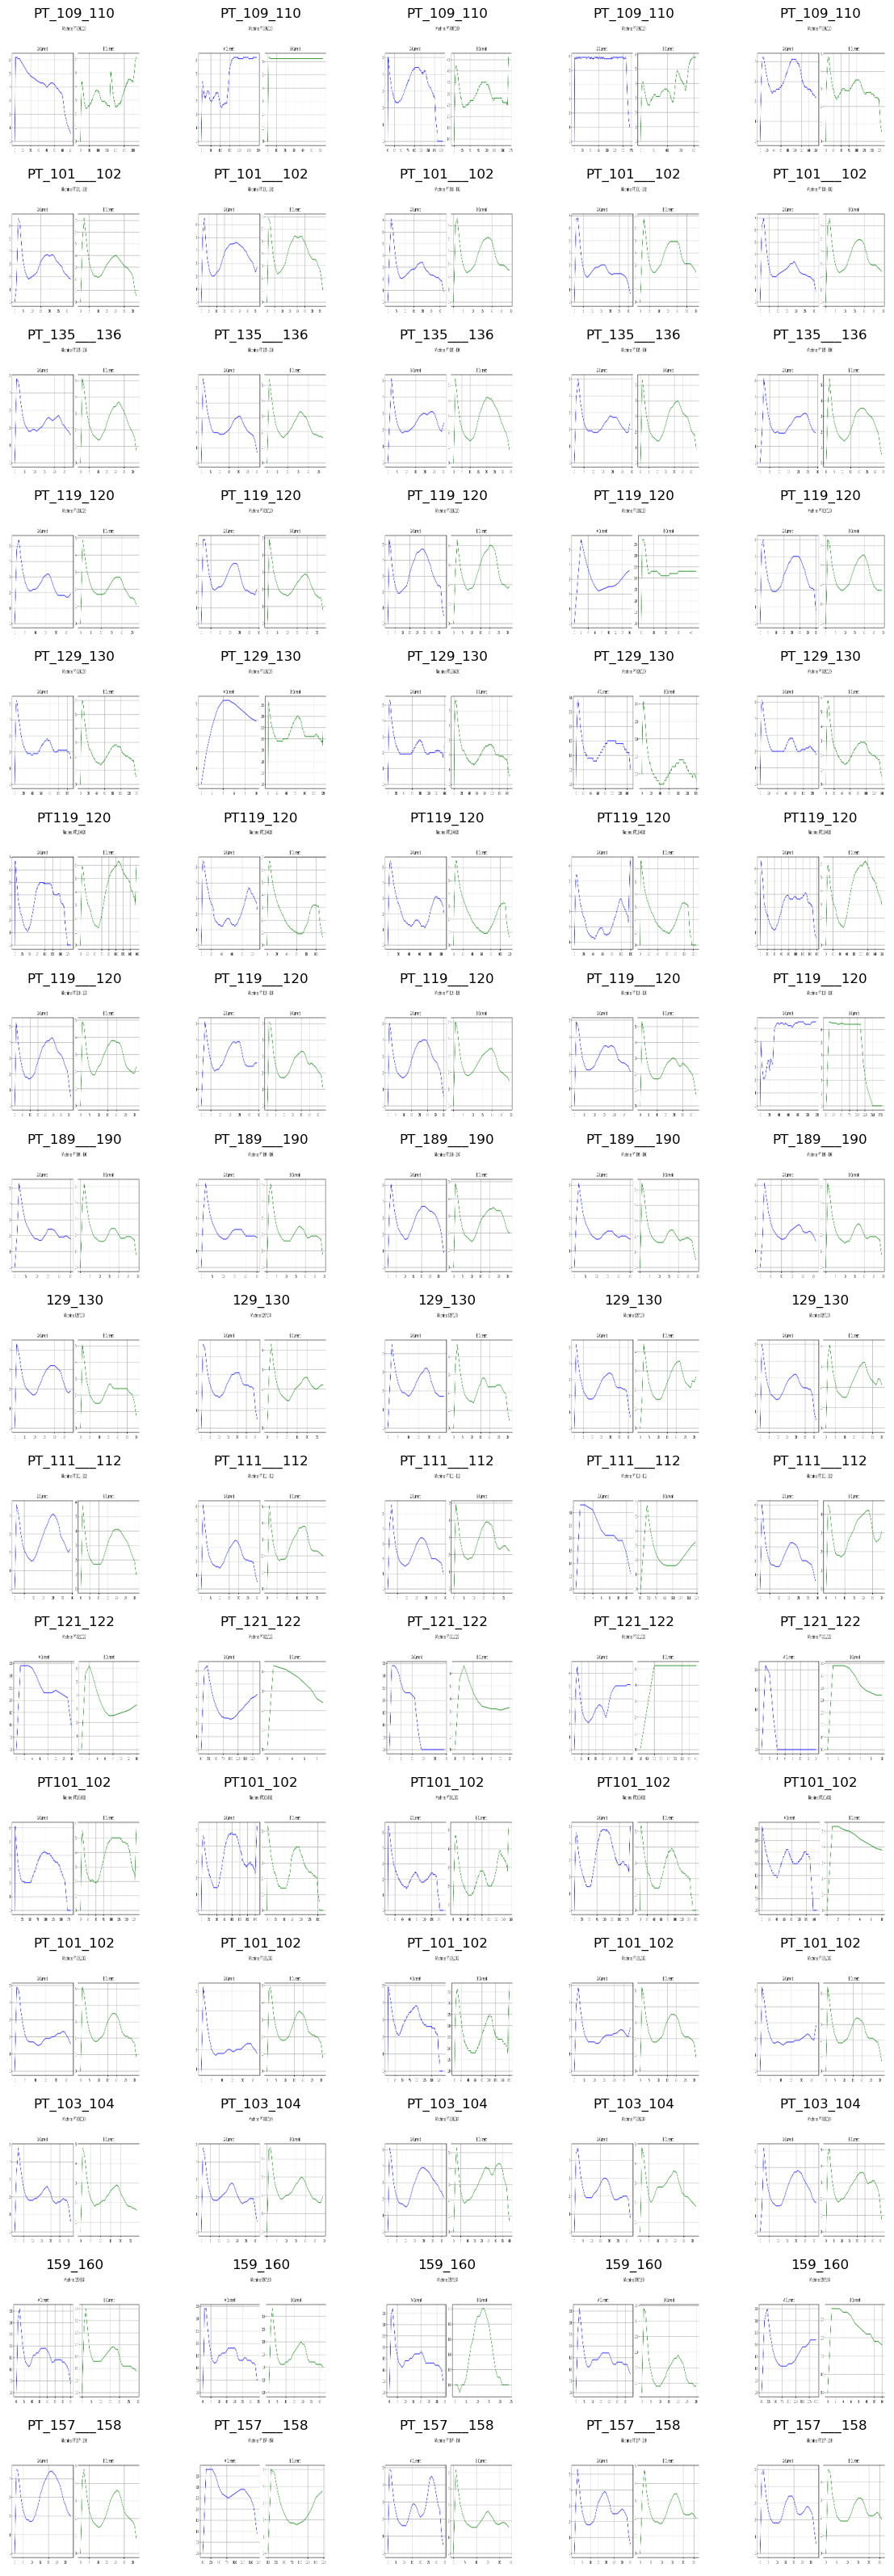

Training set: 960 images
Validation set: 320 images
Test set: 320 images


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 645ms/step - accuracy: 0.0579 - loss: 3.8601 - val_accuracy: 0.0625 - val_loss: 2.7726
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 561ms/step - accuracy: 0.0632 - loss: 2.7726 - val_accuracy: 0.0625 - val_loss: 2.7726
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 581ms/step - accuracy: 0.0580 - loss: 2.7726 - val_accuracy: 0.0625 - val_loss: 2.7726
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 604ms/step - accuracy: 0.0641 - loss: 2.7728 - val_accuracy: 0.0625 - val_loss: 2.7726
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 608ms/step - accuracy: 0.0524 - loss: 2.7726 - val_accuracy: 0.0625 - val_loss: 2.7726
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 611ms/step - accuracy: 0.0758 - loss: 2.7725 - val_accuracy: 0.0625 - val_loss: 2.7726
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 634ms/step - accuracy: 0.0572 - loss: 2.7728 - val_accuracy: 0.0625 - val_loss: 2.7726
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 627ms/step - accuracy: 0.0534 - loss: 2.7726 - val_accu

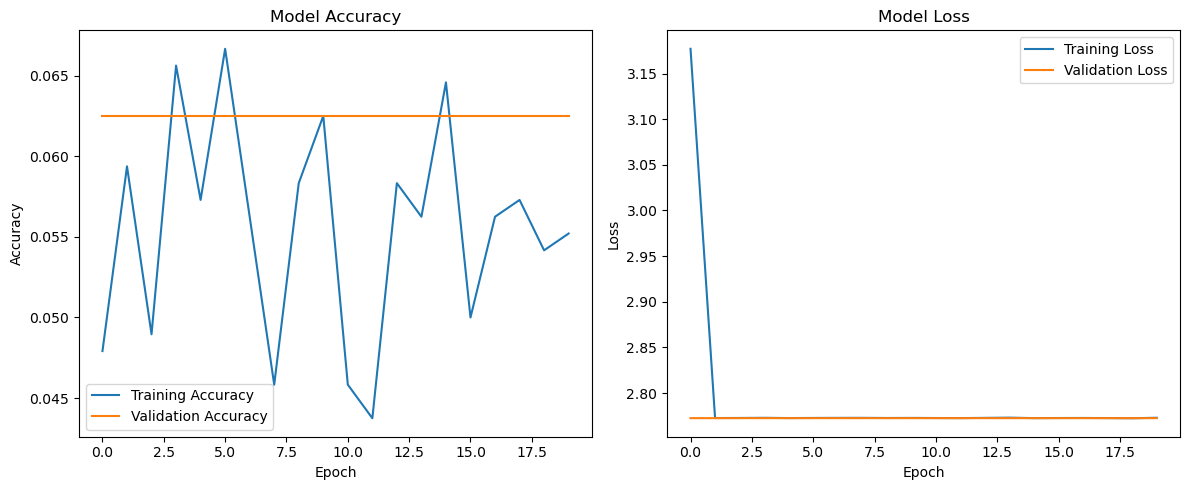


Evaluating the model...
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.0821 - loss: 2.7724
Test accuracy: 0.0625
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step

Classification Report:
              precision    recall  f1-score   support

  PT_109_110       0.00      0.00      0.00        20
PT_101___102       0.00      0.00      0.00        20
PT_135___136       0.00      0.00      0.00        20
  PT_119_120       0.00      0.00      0.00        20
  PT_129_130       0.00      0.00      0.00        20
   PT119_120       0.00      0.00      0.00        20
PT_119___120       0.00      0.00      0.00        20
PT_189___190       0.00      0.00      0.00        20
     129_130       0.00      0.00      0.00        20
PT_111___112       0.06      1.00      0.12        20
  PT_121_122       0.00      0.00      0.00        20
   PT101_102       0.00      0.00      0.00        20
  PT_101_102       0.00      0.00      0.00        20
  PT_103_104       0.00      0.00      0.00        20
  

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


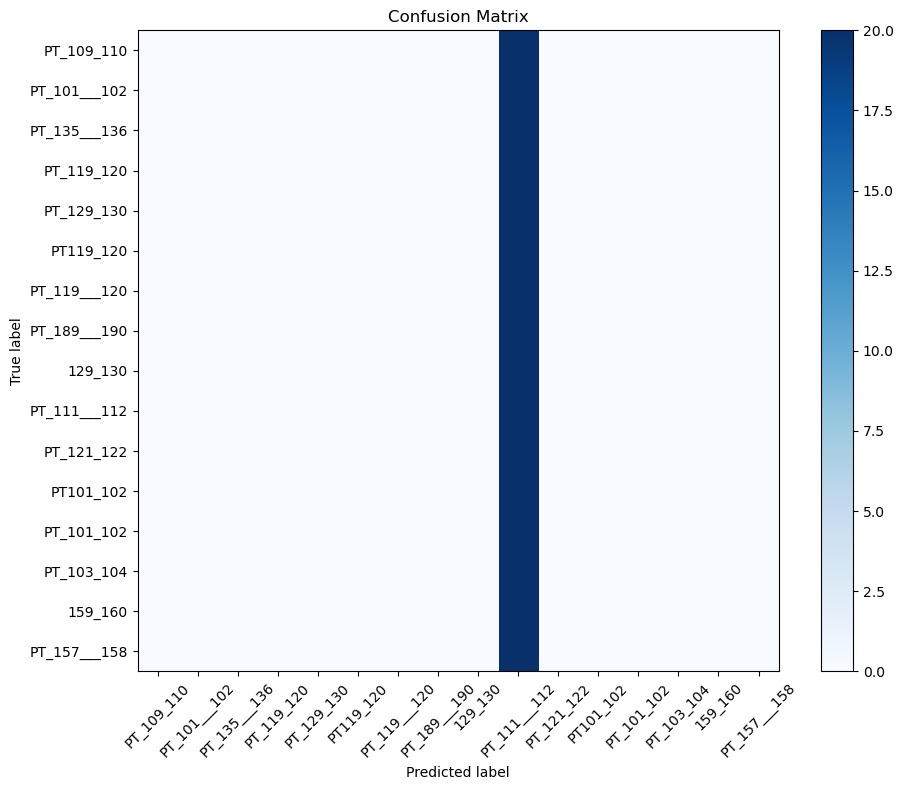


Applying anomaly detection...


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 771ms/step - loss: 0.0858 - val_loss: 0.0159
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 755ms/step - loss: 0.0158 - val_loss: 0.0159
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 756ms/step - loss: 0.0158 - val_loss: 0.0159
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 771ms/step - loss: 0.0159 - val_loss: 0.0159
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 764ms/step - loss: 0.0159 - val_loss: 0.0159
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 773ms/step - loss: 0.0158 - val_loss: 0.0159
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 762ms/step - loss: 0.0159 - val_loss: 0.0159
Epoch 8/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 778ms/step - loss: 0.0158 - val_loss: 0.0159
Epoch 9/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 767ms/step - loss: 0.0159 - val_loss: 0.0159
Epoch 10/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 776ms/step - loss: 0.0159 - val_loss: 0.0159
Epoch 11/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 819ms/step - loss: 0.0159 - val_loss: 0.0159
Epoch 12/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 31

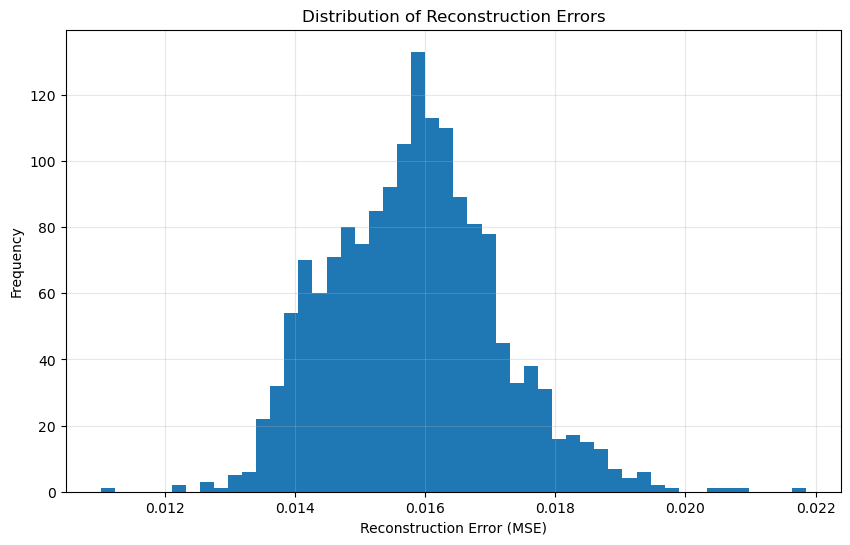

Detected 160 potential anomalies out of 1600 images


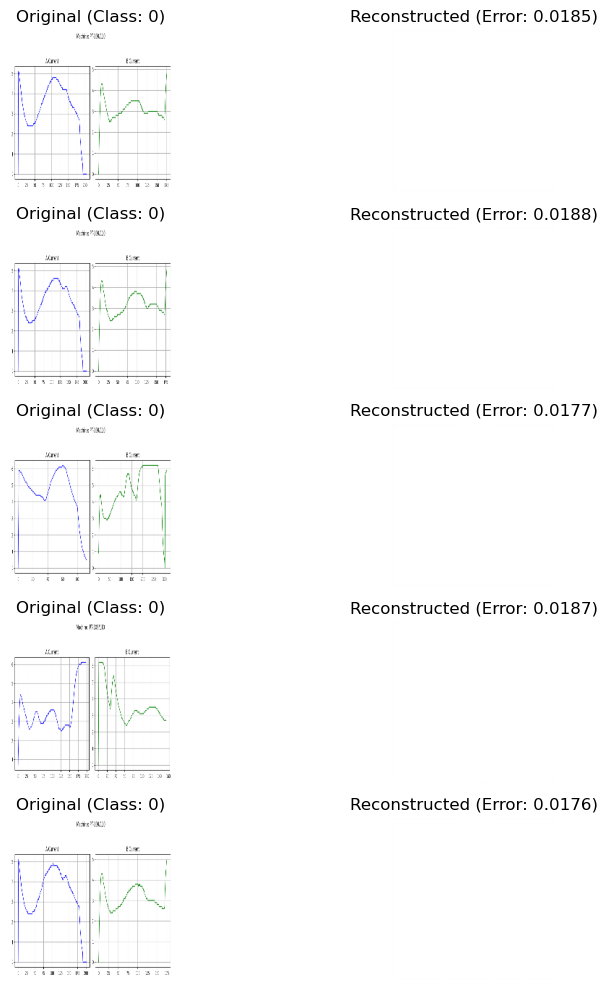


Extracting features using a pre-trained model...
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 284ms/step


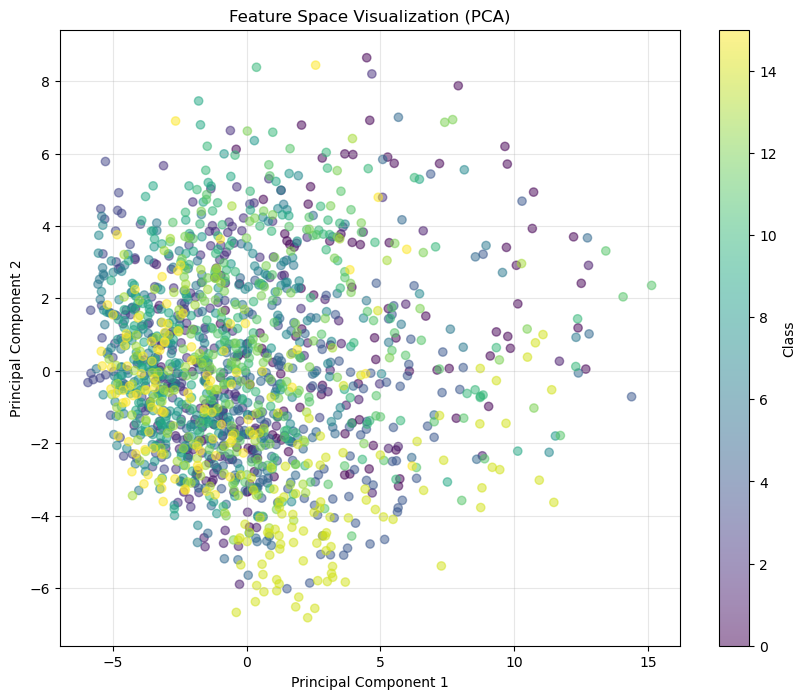


Demonstrating object detection techniques...


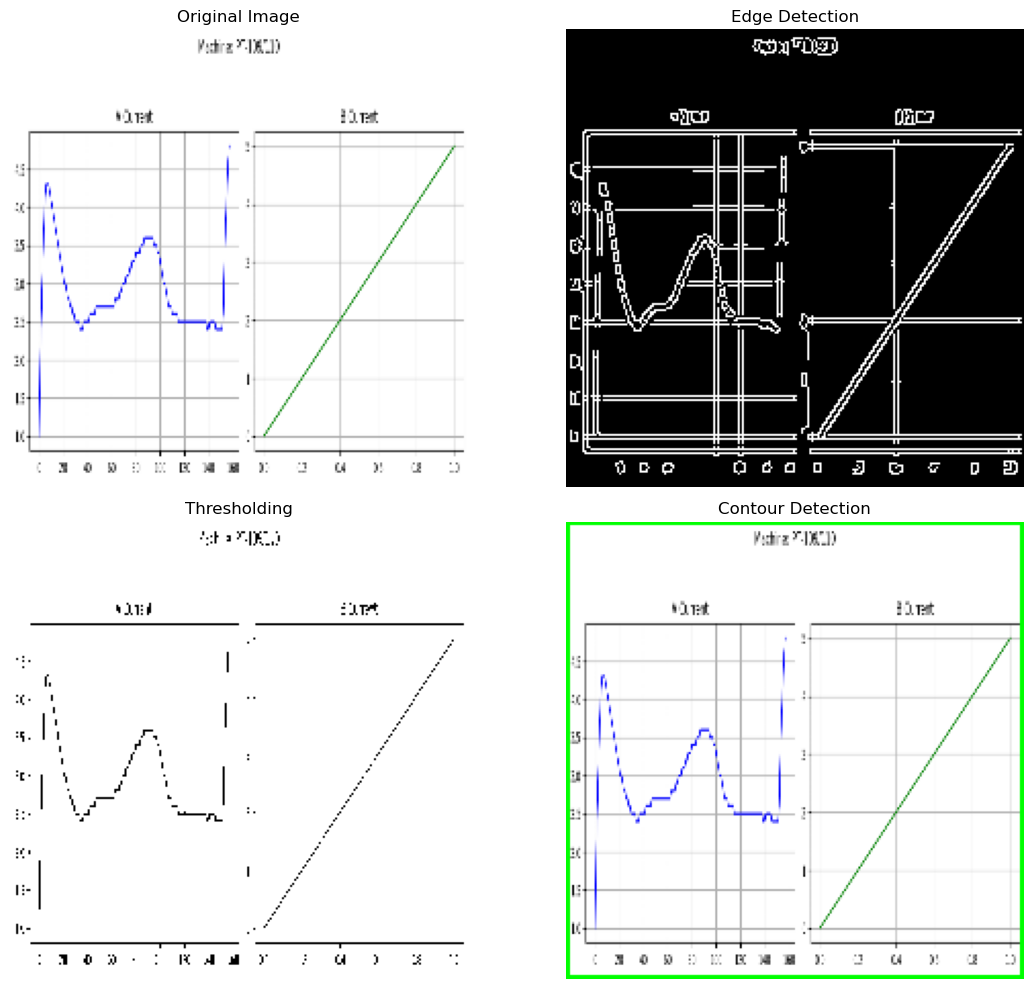


Model saved as 'point_machine_classifier.h5'

Analysis complete!


In [10]:
def main():
    print("Loading the dataset...")
    images, labels, class_names = load_dataset(ROOT_DIR)
    
    if len(images) == 0:
        print("No images found in the dataset.")
        return
    
    print(f"Loaded {len(images)} images from {len(class_names)} classes.")
    print(f"Classes: {class_names}")
    
    # Visualize samples
    visualize_samples(images, labels, class_names)
    
    # Preprocess images
    images = preprocess_images(images)
    
    # Split dataset
    train_images, test_images, train_labels, test_labels = train_test_split(
        images, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    train_images, val_images, train_labels, val_labels = train_test_split(
        train_images, train_labels, test_size=0.25, random_state=42, stratify=train_labels
    )
    
    print(f"Training set: {len(train_images)} images")
    print(f"Validation set: {len(val_images)} images")
    print(f"Test set: {len(test_images)} images")
    
    # Train the model
    model, history = train_model_with_data_augmentation(
        train_images, train_labels, val_images, val_labels
    )
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    
    # Evaluate the model
    print("\nEvaluating the model...")
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"Test accuracy: {test_acc:.4f}")
    
    predicted_classes = evaluate_model(model, test_images, test_labels, class_names)
    
    # Apply anomaly detection
    print("\nApplying anomaly detection...")
    apply_anomaly_detection(images, labels)
    
    # Extract features
    print("\nExtracting features using a pre-trained model...")
    features, features_2d = feature_extraction(images, labels)
    
    # Object detection demo
    print("\nDemonstrating object detection techniques...")
    object_detection_demo(images[0])
    
    # Save the model
    model.save('point_machine_classifier.h5')
    print("\nModel saved as 'point_machine_classifier.h5'")
    
    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()